In [1]:
%matplotlib inline

In [2]:
import os
import keras
import pickle
import umap

import numpy as np
import matplotlib.pyplot as plt

from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.manifold import TSNE
from keras.layers import Dense, Input
from keras.layers import Conv2D, Flatten, Lambda
from keras.layers import Reshape, Conv2DTranspose
from keras.models import Model
from keras.losses import mse, binary_crossentropy
from keras.utils import plot_model
from keras import backend as K
from sklearn.metrics.pairwise import cosine_similarity
from seaborn import heatmap

Using TensorFlow backend.


In [3]:
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

In [4]:
input_shape = (129, 48, 1)
intermediate_dim = 512
latent_dim = 40
batch_size = 16
kernel_size = 6
stride_size = 3
filters = 16
epochs = 100

In [5]:
def sampling(args):
    """Reparameterization trick by sampling fr an isotropic unit Gaussian.
    # Arguments
        args (tensor): mean and log of variance of Q(z|X)
    # Returns
        z (tensor): sampled latent vector
    """

    z_mean, z_log_var = args
    batch = K.shape(z_mean)[0]
    dim = K.int_shape(z_mean)[1]
    # by default, random_normal has mean=0 and std=1.0
    epsilon = K.random_normal(shape=(batch, dim))
    return z_mean + K.exp(0.5 * z_log_var) * epsilon

# VAE model = encoder + decoder
# build encoder model
inputs = Input(shape=input_shape, name='encoder_input')
x = inputs
for i in range(2):
    filters *= 2
    x = Conv2D(filters=filters,
               kernel_size=kernel_size,
               activation='tanh',
               strides=3,
               padding='valid')(x)

# shape info needed to build decoder model
shape = K.int_shape(x)

# generate latent vector Q(z|X)
x = Flatten()(x)
x = Dense(intermediate_dim, activation='tanh')(x)
z_mean = Dense(latent_dim, name='z_mean')(x)
z_log_var = Dense(latent_dim, name='z_log_var')(x)

# use reparameterization trick to push the sampling out as input
# note that "output_shape" isn't necessary with the TensorFlow backend
z = Lambda(sampling, output_shape=(latent_dim,), name='z')([z_mean, z_log_var])

# instantiate encoder model
encoder = Model(inputs, [z_mean, z_log_var, z], name='encoder')
plot_model(encoder, to_file='../data/vae_cnn_encoder.png', show_shapes=True)

# build decoder model
latent_inputs = Input(shape=(latent_dim,), name='z_sampling')
x = Dense(shape[1] * shape[2] * shape[3], activation='tanh')(latent_inputs)
x = Reshape((shape[1], shape[2], shape[3]))(x)

for i in range(2):
    x = Conv2DTranspose(filters=filters,
                        kernel_size=kernel_size,
                        activation='tanh',
                        strides=3,
                        padding='valid')(x)
    filters //= 2

outputs = Conv2DTranspose(filters=1,
                          kernel_size=kernel_size,
                          activation='sigmoid',
                          padding='same',
                          name='decoder_output')(x)

# instantiate decoder model
decoder = Model(latent_inputs, outputs, name='decoder')
plot_model(decoder, to_file='../data/vae_cnn_decoder.png', show_shapes=True)

# instantiate VAE model
outputs = decoder(encoder(inputs)[2])
vae = Model(inputs, outputs, name='vae')
plot_model(vae, to_file='../data/vae_cnn.png', show_shapes=True)

reconstruction_loss = mse(K.flatten(inputs), K.flatten(outputs))

reconstruction_loss *= input_shape[0] * input_shape[1]
kl_loss = 1 + z_log_var - K.square(z_mean) - K.exp(z_log_var)
kl_loss = K.sum(kl_loss, axis=-1)
kl_loss *= -5e-4
vae_loss = K.mean(reconstruction_loss + kl_loss)
vae.add_loss(vae_loss)
vae.compile(optimizer='rmsprop')

In [6]:
vae.load_weights('/home/ds/DataScience/Models/audio_vae/40_6_3/3.h5')

In [7]:
x_mean = pickle.load(open('../data/x_mean.pkl', 'rb'))
x_std = pickle.load(open('../data/x_std.pkl', 'rb'))

range(0, 48)


/home/ds/anaconda3/envs/audio_ae_env/lib/python3.6/site-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in log10
  


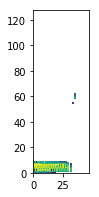

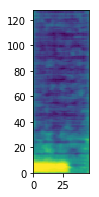

range(0, 48)


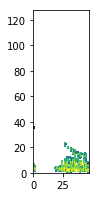

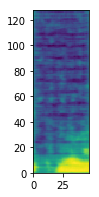

range(0, 48)


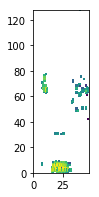

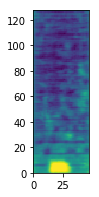

range(0, 48)


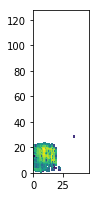

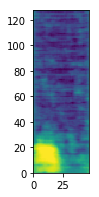

range(0, 48)


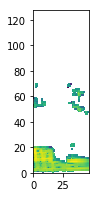

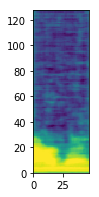

range(0, 48)


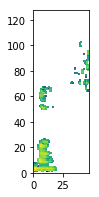

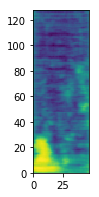

range(0, 48)


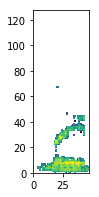

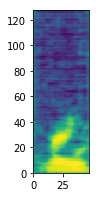

range(0, 48)


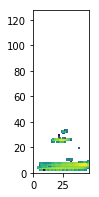

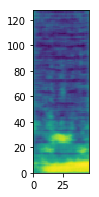

range(0, 48)


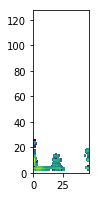

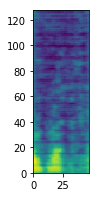

range(0, 48)


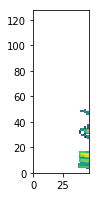

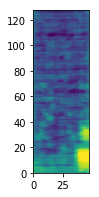

range(0, 48)


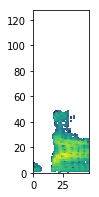

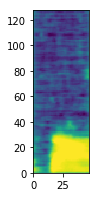

range(0, 48)


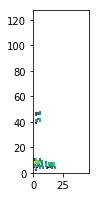

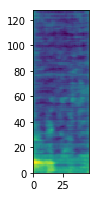

range(0, 48)


/home/ds/anaconda3/envs/audio_ae_env/lib/python3.6/site-packages/matplotlib/colors.py:918: UserWarning: Warning: converting a masked element to nan.
  dtype = np.min_scalar_type(value)
/home/ds/anaconda3/envs/audio_ae_env/lib/python3.6/site-packages/numpy/ma/core.py:713: UserWarning: Warning: converting a masked element to nan.
  data = np.array(a, copy=False, subok=subok)
/home/ds/anaconda3/envs/audio_ae_env/lib/python3.6/site-packages/matplotlib/colors.py:918: UserWarning: Warning: converting a masked element to nan.
  dtype = np.min_scalar_type(value)
/home/ds/anaconda3/envs/audio_ae_env/lib/python3.6/site-packages/numpy/ma/core.py:713: UserWarning: Warning: converting a masked element to nan.
  data = np.array(a, copy=False, subok=subok)


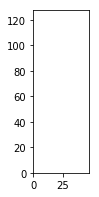

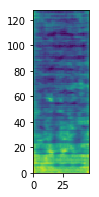

range(0, 48)


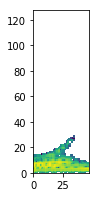

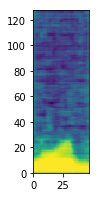

range(0, 48)


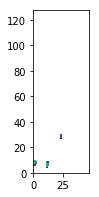

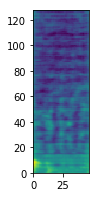

range(0, 48)


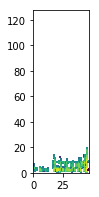

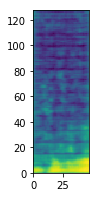

range(0, 48)


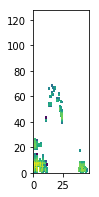

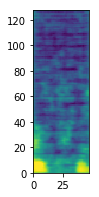

range(0, 48)


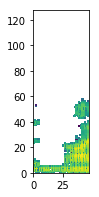

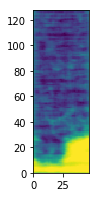

range(0, 48)


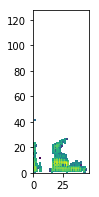

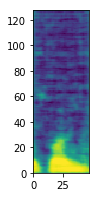

range(0, 48)


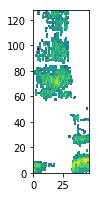

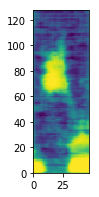

In [11]:
best_test = '/home/ds/DataScience/Datasets/LibriSpeech/VAELibriSpeech/best_test'
all_x = []
all_x_pred = []
all_y = []
for i, filename in enumerate(sorted(os.listdir(best_test))):
    x = (np.load(os.path.join(best_test, filename)) - x_mean) / x_std
    x_ing = x[np.random.choice(x.shape[0]), :, :]
    all_x += [x]
    all_y += [i]*x.shape[0]
    plt.figure(figsize=(1, 3))
    print(range(x_ing.shape[1]))
    plt.pcolormesh(range(x_ing.shape[1]),
                   range(x_ing.shape[0]),
                   10*np.log10(x_ing))
    plt.savefig('../data/{}_true.png'.format(filename))
    plt.show()
    x_pred = vae.predict(x_ing.reshape((1,
                                        x_ing.shape[0],
                                        x_ing.shape[1], 1))).reshape((x_ing.shape[0],
                                                                      x_ing.shape[1]))
    all_x_pred += [x_pred]
    plt.figure(figsize=(1, 3))
    plt.pcolormesh(range(x_pred.shape[1]),
                   range(x_pred.shape[0]),
                   10*np.log10(x_pred))
    plt.savefig('../data/{}_reconstr.png'.format(filename))
    plt.show()
all_x = np.vstack(all_x)
all_y = np.stack(all_y)

In [8]:
all_x = []
all_y = []
speaker_ids = ["1089", "1188", "121", "1221", "1284", "1320", "1580",
               "1995", "2094", "2300", "237", "260", "2830", "2961",]
other_ids = ["3570", "3575", "3729", "4077", "4446", "4507", "4970",
               "4992", "5105", "5142", "5639", "5683", "61", "672",
               "6829", "6930", "7021", "7127", "7176", "7729", "8224",
               "8230", "8455", "8463", "8555", "908"]
feats_path = '/home/ds/DataScience/Datasets/LibriSpeech/VAELibriSpeech/test-clean-wav/'
for filename in sorted(os.listdir(feats_path)):
    cur_speaker_id = None
    for speaker_id in speaker_ids:
        if filename.startswith(speaker_id + '-'):
            cur_speaker_id = speaker_id
    if cur_speaker_id == None:
        continue
    all_y += [cur_speaker_id]
    x_file = np.load(os.path.join(feats_path, filename))
    x_file = (x_file - x_mean) / x_std
    all_x_encoded = encoder.predict(x_file.reshape(x_file.shape + (1,)))[2]
    all_x += [np.max(all_x_encoded, axis=0)]
all_x = np.stack(all_x)
all_y = np.stack(all_y)

In [9]:
decomposition = PCA(n_components=2)

In [10]:
ids2labels = {speaker_id: i for i, speaker_id in enumerate(speaker_ids)}

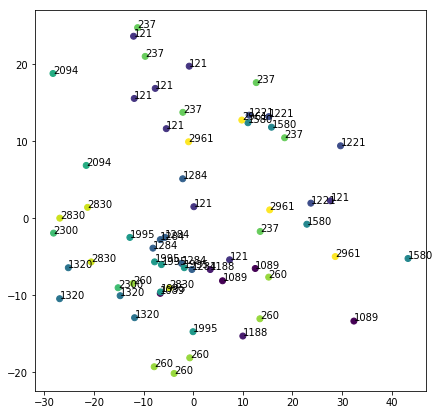

In [11]:
# Translate into the latent space
x_embedded = decomposition.fit_transform(all_x)
fig, ax = plt.subplots(figsize=(7, 7))
ax.scatter(x_embedded[:, 0], x_embedded[:, 1], c=[ids2labels[speaker_id]*30 for speaker_id in all_y])

for i, txt in enumerate(all_y):
    ax.annotate(txt, (x_embedded[i, 0], x_embedded[i, 1]))
#plt.colorbar()
plt.savefig('../data/speakers_plot.png')
plt.show()

In [12]:
all_x = []
all_y = []
feats_path = '/home/ds/DataScience/Datasets/LibriSpeech/VAELibriSpeech/test-words-feats/'
for filename in sorted(os.listdir(feats_path)):
    x_file = np.load(os.path.join(feats_path, filename))
    x_file = (x_file - x_mean) / x_std
    all_x_encoded = encoder.predict(x_file.reshape(x_file.shape + (1,)))[2]
    all_x += [np.max(all_x_encoded, axis=0)]
    all_y += [filename]
all_x = np.stack(all_x)
all_y = np.stack(all_y)

In [13]:
decomposition = PCA(n_components=2)

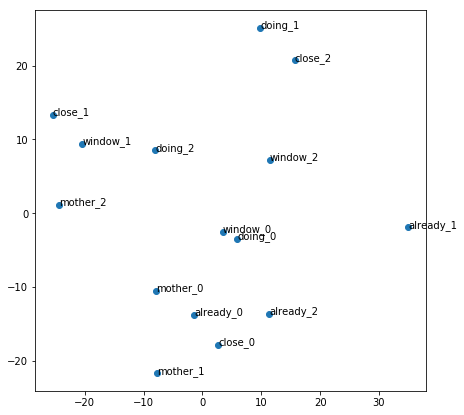

In [14]:
# Translate into the latent space
x_embedded = decomposition.fit_transform(all_x)
fig, ax = plt.subplots(figsize=(7, 7))
ax.scatter(x_embedded[:, 0], x_embedded[:, 1])

for i, txt in enumerate(all_y):
    ax.annotate(txt, (x_embedded[i, 0], x_embedded[i, 1]))
#plt.colorbar()
plt.savefig('../data/words_plot.png')
plt.show()

In [33]:
x_embedded.shape

(3, 2)